In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import seaborn as sns
from sklearn.model_selection import  train_test_split
from keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet50 import ResNet50



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

using Keras- preprocessing to manage the dataset

In [3]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../input/tomato-leaf-disease/Tomato Leaf Diseases/Training Set/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../input/tomato-leaf-disease/Tomato Leaf Diseases/Validation Set/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))

Found 10000 files belonging to 10 classes.
Found 7000 files belonging to 10 classes.


Taking a look at the diffrenet categories

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


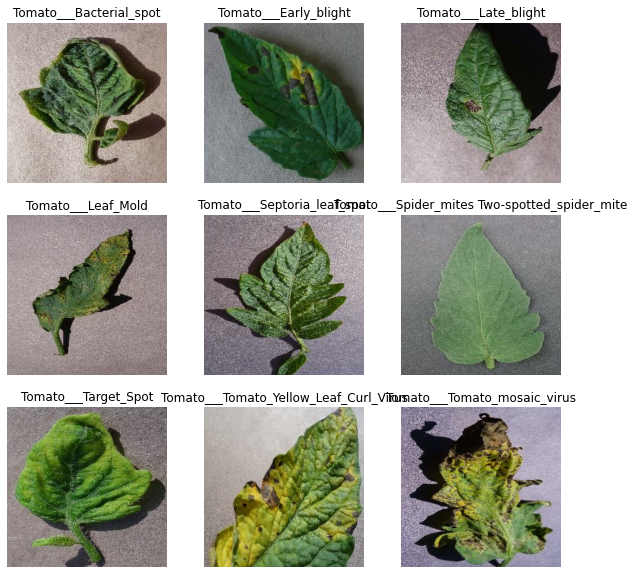

In [4]:
class_names = train_ds.class_names
classes = train_ds.class_names

print(class_names)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")


Adding some dataAugmentation to the data set

In [6]:

data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256, 
                                                              256,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Simple model with couple of dropouts.

In [7]:
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256, 
                                                              256,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = tf.keras.models.Sequential([
    # This is the first convolution
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


adam = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

two optional callbacks to customize, i prefer using the Checkpoint one here.

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') > 0.985:
      print("\n reached 98.5% accuracy so canceling training!")
      self.model.stop_training=True

In [ ]:
epochs = 10
filepath="CNNweights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#callbacks=myCallback()
history = model.fit(train_ds, batch_size=32, epochs=epochs,
validation_data=validation_ds,callbacks=callbacks_list)

Epoch 1/10
  9/313 [..............................] - ETA: 35:49 - loss: 2.3038 - accuracy: 0.0694

0.973 accuracy on val set! thats amazing! 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Loading the best Model from training!

In [ ]:
model.save('saved_model/my_model')
new_model = tf.keras.models.load_model(filepath)
new_model.summary()


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the model.
with open('CNNmodel.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#image='/kaggle/input/TomatoLeaf/a.png'
#image='/kaggle/input/TomatoLeaf/4a52febc9b1b81772f71572702326631.jpg'
image='/kaggle/input/TomatoLeaf/septoria-leaf-spot3.jpg'



img = tf.keras.preprocessing.image.load_img(
    image, target_size=(256, 256)
)
plt.imshow(img)
plt.show()
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batc
pred=new_model.predict_classes(img_array)

print(f'the predicted label is: {class_names[int(pred)]}')
print(f' the model is sure about it in :{new_model.predict(img_array)[0][pred]}')


plt.show()



showing some pictures from the category that was predicted

In [ ]:
plt.figure(figsize=(10, 10))

pred=(int(pred))
print(class_names[pred])
path = f"../input/tomato-leaf-disease/Tomato Leaf Diseases/Training Set/{class_names[pred]}/"   
import random
pics=[]
for r, d, f in os.walk(path):
    for file in f:
        pics.append(os.path.join(r, file))
        
for i in range(0,9):
    plt.subplot(331+i)
    img= cv2.imread(pics[random.randint(0, 999)])
    plt.imshow(img)
    
plt.show()
          

Trying out Resnet50 *not finished yet*

In [ ]:
ResNetModel = ResNet50(weights=None,input_shape=(256,256,3),include_top=False)
for layer in ResNetModel.layers:
  layer.trainable=False
  
# Print the model summary
#ResNetModel.summary()

In [ ]:
from tensorflow.keras import Model

last_layer = ResNetModel.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(10,activation='softmax')(x)           

ResNetModel = Model(ResNetModel.input, x) 


ResNetModel.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
#ResNetModel.summary()

In [ ]:
epochs=50
filepath="RESNETweights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = ResNetModel.fit(train_ds, batch_size=32, epochs=epochs,
validation_data=validation_ds,callbacks=callbacks_list)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(ResNetModel)
tflite_model = converter.convert()

# Save the model.
with open('RESNETmodel.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#image='/kaggle/input/TomatoLeaf/a.png'
#image='/kaggle/input/TomatoLeaf/4a52febc9b1b81772f71572702326631.jpg'
image='/kaggle/input/TomatoLeaf/septoria-leaf-spot3.jpg'



img = tf.keras.preprocessing.image.load_img(
    image, target_size=(256, 256)
)
plt.imshow(img)
plt.show()
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batc
pred=ResNetModel.predict_classes(img_array)

print(f'the predicted label is: {class_names[int(pred)]}')
print(f' the model is sure about it in :{ResNetModel.predict(img_array)[0][pred]}')


plt.show()



In [ ]:
plt.figure(figsize=(10, 10))

pred=(int(pred))
print(class_names[pred])
path = f"../input/tomato-leaf-disease/Tomato Leaf Diseases/Training Set/{class_names[pred]}/"   
import random
pics=[]
for r, d, f in os.walk(path):
    for file in f:
        pics.append(os.path.join(r, file))
        
for i in range(0,9):
    plt.subplot(331+i)
    img= cv2.imread(pics[random.randint(0, 999)])
    plt.imshow(img)
    
plt.show()
          